# Custom models and its evaluation

This practice purposed to cover 3 technical topics using theoretical framework, you met on lections, but not only.

These topics are:

1.   Custom goal function and its optimization (using MAPE as example).
2.   Preprocessing pipelines (using polynomial features as example).
3.   Hyper-parameters tuning using Cross-validation.

All examples are made with the same artificial regression data. I encourage you to try it on your dataset and also classification task!


### Tasks

1. Implement L1 and L2 (or Lp) regularization for polynomial regression and use Cross-Validation to find optimal regularization method and coefficient (5 p.)
2. Use regularization for to reduce number of features in polynomial regression (3 b.)
3. Implement your own loss and objective function (2 b.)
4. Implement weighted linear regression and use cross-validation to find optimal $\sigma$ parameter (5 b.)
5. Remade the whole document to solve classification task (5 b.)

Any experiments will be appreciated and evaluated.

In [123]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

%matplotlib inline

In [124]:
plt.rcParams['figure.figsize'] = [20, 8]

## Get data

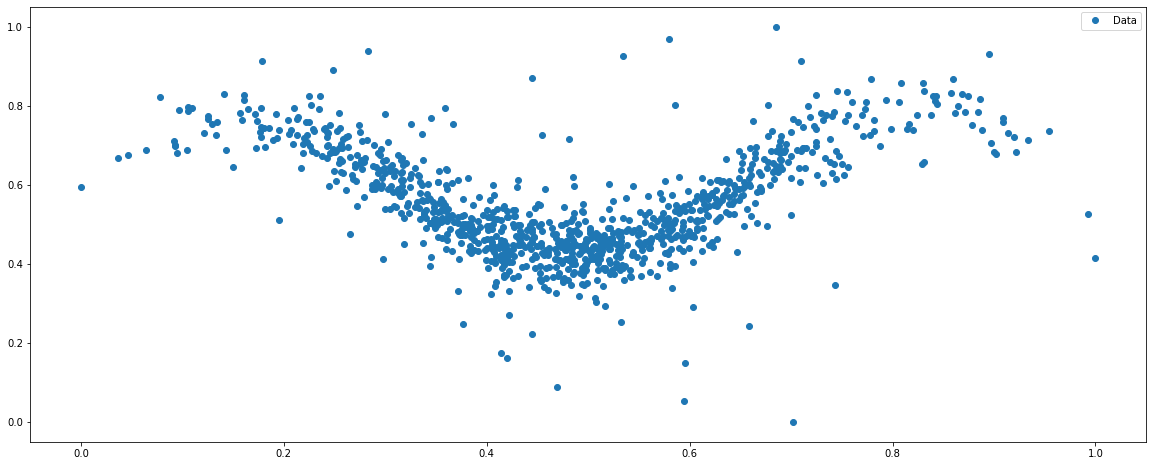

In [125]:
# Generate nonlinear data with outliers.
# Don't hesitate to change the generation parameters, method and data itself! Observe, how it changes results
n_samples = 1000
n_outliers = 100

X, y = datasets.make_regression(n_samples=n_samples,
                                n_features=1,
                                n_informative=1,
                                noise=25,
                                coef=False,
                                random_state=1110)

# Replace first N samples with outliers
X[:n_outliers] = np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = 100 * np.random.normal(size=n_outliers)

# Add non-linearity to data
y = y + 100 * X.T[0] * np.sin(X.T[0])

# Scale data to put in range [0, 1] for stability.
# Check results if ignore it.

# See also sklearn User Guide (https://scikit-learn.org/stable/modules/preprocessing.html#scaling-features-to-a-range)
# and try another tools (Standartization, Normalization)
X = (X - X.min()) / (X.max() - X.min())
y = (y - y.min()) / (y.max() - y.min())

plt.plot(X, y, 'o', label='Data')
plt.legend()

In [126]:
# Add bias column to data
X_I = np.c_[np.ones_like(X), X]

## Define Model

### Mean Absolute Percentage Error (MAPE)

Let's use [Mean Absolute Percentage Error](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) as a custom error function:

$$ \text{MAPE} = \frac{1}{n}\sum_i \left| \frac{y_i - \hat{y_i}}{y_i} \right| \cdot 100\%$$

This function uses percentage ratio between error and original value to express forecast accuracy, which is much more interpretable, than absolute error. 

You can try your loss function here! Figure out something or google anything like 'Best regression loss function'. The only what matters is to y_true and y_pred on input and return single value.

In [127]:
# true: Array of true target variable
# pred: Array of predictions

# Mean Absolute Percentage Error (MAPE)
def mape(y_true, y_pred):
    assert len(y_true) == len(y_pred), "TrueTarget and Prediction arrays length should be equal"
    
    y_true = np.asanyarray(y_true)
    y_pred = np.asanyarray(y_pred)

    if np.any(y_true == 0):
        # print("Found zeroes in y_true. MAPE is undefined. Removing it from set.")
        idx = np.where(y_true == 0)

        y_true = np.delete(y_true, idx)
        y_pred = np.delete(y_pred, idx)
        # print("%i samples deleted" %len(idx))

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0

# Mean Square Error (MSE), Quadratic loss, L2 Loss
def mse(y_true, y_pred):
    assert len(y_true) == len(y_pred), "TrueTarget and Prediction arrays length should be equal"

    y_true = np.asanyarray(y_true)
    y_pred = np.asanyarray(y_pred)

    if np.any(y_true == 0):
        idx = np.where(y_true == 0)

        y_true = np.delete(y_true, idx)
        y_pred = np.delete(y_pred, idx)

    return np.sum((y_true - y_pred) ** 2)


# Mean Absolute Error (MAE), L1 Loss
def mae(y_true, y_pred):
    assert len(y_true) == len(y_pred), "TrueTarget and Prediction arrays length should be equal"

    y_true = np.asanyarray(y_true)
    y_pred = np.asanyarray(y_pred)

    if np.any(y_true == 0):
        idx = np.where(y_true == 0)

        y_true = np.delete(y_true, idx)
        y_pred = np.delete(y_pred, idx)

    return np.sum(np.abs(y_true - y_pred))


# MSE, MAE also available in sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Huber Loss, Smooth Mean Absolute Error
def huber(true, pred, delta=1):
    assert len(true) == len(pred), "TrueTarget and Prediction arrays length should be equal"

    true = np.asanyarray(true)
    pred = np.asanyarray(pred)

    if np.any(true == 0):
        idx = np.where(true == 0)

        true = np.delete(true, idx)
        pred = np.delete(pred, idx)

    loss = np.where(np.abs(true - pred) < delta, 0.5 * ((true - pred) ** 2), delta * np.abs(true - pred) - 0.5 * (delta ** 2))
    return np.sum(loss)


# Log-Cosh Loss
def logcosh(true, pred):
    assert len(true) == len(pred), "TrueTarget and Prediction arrays length should be equal"

    true = np.asanyarray(true)
    pred = np.asanyarray(pred)

    if np.any(true == 0):
        idx = np.where(true == 0)

        true = np.delete(true, idx)
        pred = np.delete(pred, idx)

    loss = np.log(np.cosh(pred - true))
    return np.sum(loss)


In [128]:
y_pred = np.random.random(len(y))

print('mape - Error of random prediction: %.2f%%'%mape(y, y_pred))
print('mse - Error of random prediction: %.2f%%'%mse(y, y_pred))
print('mae - Error of random prediction: %.2f%%'%mae(y, y_pred))
print('sklearn mean_squared_error - Error of random prediction: %.2f%%'%mean_squared_error(y, y_pred))
print('sklearn mean_absolute_error - Error of random prediction: %.2f%%'%mean_absolute_error(y, y_pred))
print('huber delta 0.1 - Error of random prediction: %.2f%%'%huber(y, y_pred, 0.1))
print('huber delta 1 - Error of random prediction: %.2f%%'%huber(y, y_pred, 1))
print('huber delta 10 - Error of random prediction: %.2f%%'%huber(y, y_pred, 10))
print('logcosh - Error of random prediction: %.2f%%'%logcosh(y, y_pred))

mape - Error of random prediction: 52.37%
mse - Error of random prediction: 101.74%
mae - Error of random prediction: 265.41%
sklearn mean_squared_error - Error of random prediction: 0.10%
sklearn mean_absolute_error - Error of random prediction: 0.27%
huber delta 0.1 - Error of random prediction: 21.92%
huber delta 1 - Error of random prediction: 50.87%
huber delta 10 - Error of random prediction: 50.87%
logcosh - Error of random prediction: 49.03%


In [129]:
def predict(X, theta):
    return np.dot(X, theta)

In [130]:
y_pred = predict(X_I, theta=np.random.random(len(X_I[0])))

print('mape - Error of random prediction: %.2f%%'%mape(y, y_pred))
print('mse - Error of random prediction: %.2f%%'%mse(y, y_pred))
print('mae - Error of random prediction: %.2f%%'%mae(y, y_pred))
print('sklearn mean_squared_error - Error of random prediction: %.2f%%'%mean_squared_error(y, y_pred))
print('sklearn mean_absolute_error - Error of random prediction: %.2f%%'%mean_absolute_error(y, y_pred))
print('huber delta 0.1 - Error of random prediction: %.2f%%'%huber(y, y_pred, 0.1))
print('huber delta 1 - Error of random prediction: %.2f%%'%huber(y, y_pred, 1))
print('huber delta 10 - Error of random prediction: %.2f%%'%huber(y, y_pred, 10))
print('logcosh - Error of random prediction: %.2f%%'%logcosh(y, y_pred))

mape - Error of random prediction: 93.77%
mse - Error of random prediction: 223.13%
mae - Error of random prediction: 440.62%
sklearn mean_squared_error - Error of random prediction: 0.22%
sklearn mean_absolute_error - Error of random prediction: 0.44%
huber delta 0.1 - Error of random prediction: 39.18%
huber delta 1 - Error of random prediction: 111.57%
huber delta 10 - Error of random prediction: 111.57%
logcosh - Error of random prediction: 106.44%


Define objective (goal) function as $L(\theta|X,y) = MAPE(y, h(\theta|X))$

To make it compatible with optimization procedure, put optimizied parameter _theta_ on the first place in arguments. 

Optionally: try to add something usef objective function more complicated.

In [131]:
def objective_function(theta, X, y, loss_function=mape):
    y_true = np.asanyarray(y)
    y_pred = predict(X, theta)
  
    return loss_function(y_true, y_pred)

Visualize objective function surface

In [132]:
size = 100 # amount of tries for each parameter
limits = (-100, 100) # range of values for each parameter
error = np.zeros((size, size)) # empty matrix of errors

for i,w in enumerate(np.linspace(*limits, size)): # for each theta[0] component
    for j,b in enumerate(np.linspace(*limits, size)): # for each theate[1] component
        error[i,j] = objective_function(np.array([b, w]), X_I, y, mape) # compute cost for each theta

In [133]:
from mpl_toolkits.mplot3d import Axes3D

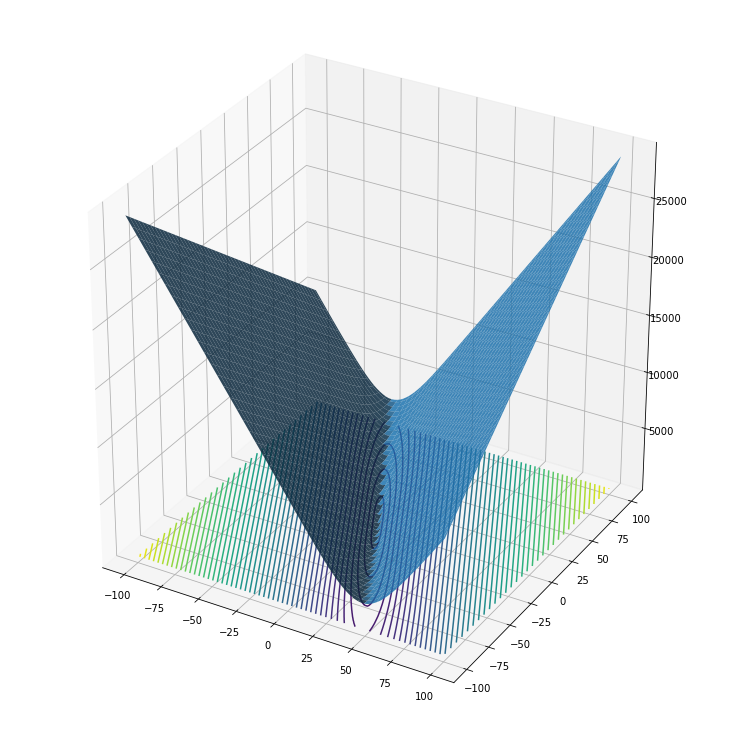

In [134]:
# initialize figure
fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig)

# create 2d array for each index 
K, L = np.meshgrid(np.linspace(*limits, size), np.linspace(*limits, size))

ax.plot_surface(K, L, Z=error, alpha=0.85) # plot cost function surface in 3d
plt.contour(K, L, error, 50, offset=1) # plot cost function 2d-projection

## Train model

We're done with defining gradient descent step manually!

There are less efficient but more universal approaches, for example use numerical optimization methods. 

Let's try [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html).

In [135]:
from scipy import optimize

In [136]:
theta_init = np.array([1] * X_I.shape[1]) # initial value of theta

result_powell = optimize.minimize(objective_function,  # function to optimize. Parameter to optimize should the first argument 
                           args=(X_I, y, mape), # other arguments of the function
                           x0=theta_init,       # initial value of parameter to optimize
                           method='Powell',     # optimization method. Try also BFGS, Nelder-Mead, Powell, CG, TNC and others (see docs). Effectivnes can change dramatically!
                           options={})          # arguments of optimization method, like number of iterations, learning rate, etc.

result_bfgs = optimize.minimize(objective_function,
                           args=(X_I, y, mape),
                           x0=theta_init,
                           method='BFGS',
                           options={})

result_nelder_mead = optimize.minimize(objective_function,
                           args=(X_I, y, mape),
                           x0=theta_init,
                           method='Nelder-Mead',
                           options={})

result_cg = optimize.minimize(objective_function,
                           args=(X_I, y, mape),
                           x0=theta_init,
                           method='CG',
                           options={})

result_tnc = optimize.minimize(objective_function,
                           args=(X_I, y, mape),
                           x0=theta_init,
                           method='TNC',
                           options={})

result = result_powell

In [137]:
print('\n Powell \n')
print(result_powell)

print('\n BFGS \n')
print(result_bfgs)

print('\n Nelder-Mead \n')
print(result_nelder_mead)

print('\n CG \n')
print(result_cg)

print('\n TNC \n')
print(result_tnc)


 Powell 

   direc: array([[ 0.51681038, -0.94965446],
       [ 0.00917695, -0.02688273]])
     fun: 20.46610856210269
 message: 'Optimization terminated successfully.'
    nfev: 184
     nit: 5
  status: 0
 success: True
       x: array([ 0.54569207, -0.12193373])

 BFGS 

      fun: 20.466105304447368
 hess_inv: array([[ 0.00030398, -0.0008364 ],
       [-0.0008364 ,  0.0023831 ]])
      jac: array([-0.12858605, -0.04155564])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 444
      nit: 12
     njev: 108
   status: 2
  success: False
        x: array([ 0.5457366 , -0.12201607])

 Nelder-Mead 

 final_simplex: (array([[ 0.54569093, -0.12192305],
       [ 0.54566333, -0.1218388 ],
       [ 0.54566801, -0.12187468]]), array([20.4661085 , 20.46610998, 20.46611008]))
           fun: 20.46610850457789
       message: 'Optimization terminated successfully.'
          nfev: 95
           nit: 48
        status: 0
       success: True
             x: ar

Optimization results come in the special object. Here what we are interested in:

In [138]:
print('Optimization result:', ['FAIL', 'Success'][result.success])
print('Comment:', result.message)
print('Objective function value:', result.fun)
print('Found theta:', result.x)

Optimization result: Success
Comment: Optimization terminated successfully.
Objective function value: 20.46610856210269
Found theta: [ 0.54569207 -0.12193373]


The most common reason of optimization fail is _'Desired error not necessarily achieved due to precision loss'_. It means, that on some point the procedure became numerically unstable, usually because of too big or too small values of objective function. 

If this point wasn't too close, results are still usable. 

There is also some chance to make result better with changing _theta_init_  or just re-running the function, and, the most reliable, change optimization method's options and method itself.

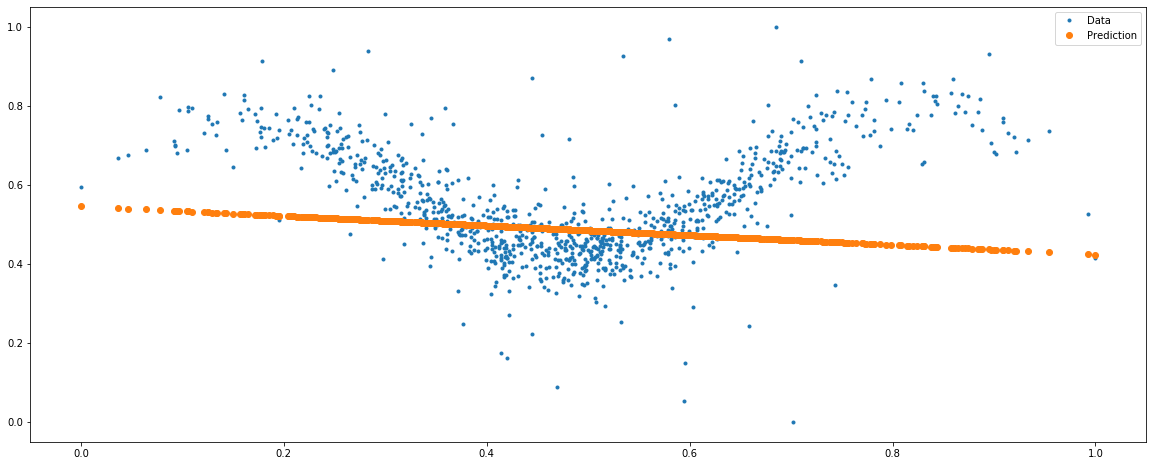

In [139]:
# Visualize result
theta = result.x
y_pred = predict(X_I, theta)

plt.plot(X, y, '.', label='Data')
plt.plot(X, y_pred, 'o', label='Prediction')
plt.legend()

In [140]:
# For further use, let's make universal function to train regression model with any objective and loss functions
def custom_regression(X,
                      y, 
                      objective_function=objective_function, 
                      loss_function=mape, 
                      init=1, 
                      verbose=True, 
                      iters=10):
  
    theta_init = np.ones_like(X[0]) * init
    result = optimize.minimize(objective_function,
                               args=(X, y, loss_function), 
                               x0=theta_init, 
                               method='BFGS', 
                               options={'maxiter': iters})
    theta = result['x']
    
    if verbose:
        print(result['fun'])

    return theta

## Add polynomial features

In [141]:
from sklearn.preprocessing import PolynomialFeatures

In [142]:
n = 10 # power of polynom
polynomial_features = PolynomialFeatures(degree=n, include_bias=True) # create instance of preprocessor
X_a = polynomial_features.fit_transform(X) # apply transformation
X_a.shape

(1000, 11)

In [143]:
theta = custom_regression(X_a, y, objective_function=objective_function, loss_function=mape)

12.18894522721505


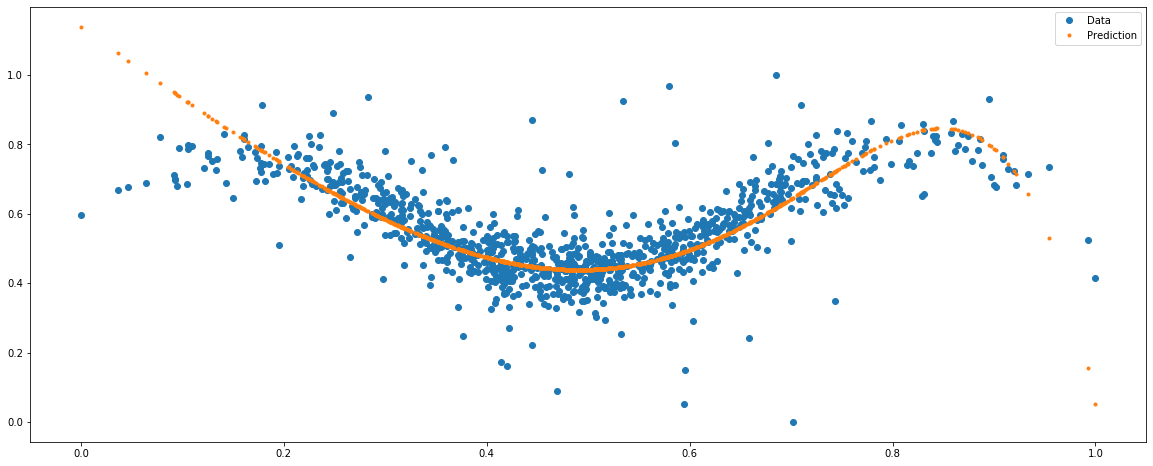

In [144]:
y_pred = predict(X_a, theta)

plt.plot(X, y, 'o', label='Data')

ax = plt.gca()
ax.autoscale(enable=True)

plt.plot(X, y_pred, '.', label='Prediction')
plt.legend()

In [145]:
from sklearn.model_selection import train_test_split

In [146]:
# Split data to test and train in sklearn style
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

degrees = [1, 2, 5, 10, 25, 50, 500]

18.919444122423606
12.815922232979304
10.551417860057299
10.165741821219344
10.903858714324242
10.72686794985823
10.922590103920845
Wall time: 1.61 s


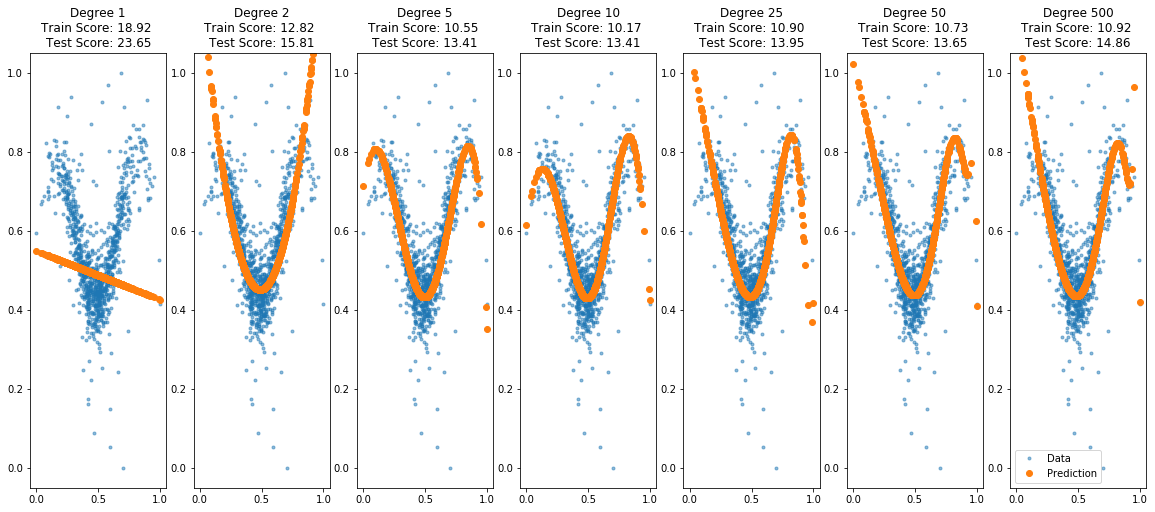

In [147]:
%%time

for i, n in enumerate(degrees):
    polynomial_features = PolynomialFeatures(degree=n, include_bias=True)

    # make transformation of all data subsets
    X_all = polynomial_features.fit_transform(X)
    X_a_train = polynomial_features.fit_transform(X_train)
    X_a_test = polynomial_features.fit_transform(X_test)

    # train model
    theta = custom_regression(X_a_train,
                              y_train,
                              objective_function=objective_function,
                              loss_function=mape,
                              iters=20)

    # test model
    y_pred_test = predict(X_a_test, theta)
    y_pred_train = predict(X_a_train, theta)
    test_score = objective_function(theta=theta, X=X_a_test, y=y_test)
    train_score = objective_function(theta=theta, X=X_a_train, y=y_train)

    #visualize results
    y_pred = predict(X_all, theta)
  
    ax = plt.subplot(1, len(degrees), i + 1)
    ax.plot(X, y, '.', alpha=0.5, label='Data')
    ax.autoscale(enable=False)
    ax.plot(X, y_pred, 'o', label='Prediction')

    plt.title("Degree %i\nTrain Score: %.2f \nTest Score: %.2f"%(degrees[i], train_score, test_score))

plt.legend()

## Evaluate result

To make convenient and safe using of our approach (preprocessing + modelling) we can use great sklearn instument called [Pipelines](https://scikit-learn.org/stable/modules/compose.html#pipelines-and-composite-estimators).

Pipeline can include any number of data transformations and modelling, and than be treated as a single sklearn object.

To make it possible, all models of sklearn inherits the same interface, which essentialy should have just few methods:
* ```__init__()```, that should be able to be called without arguments and create an instance with no dependencies to data.
* ```fit()```, that takes data and make all data-dependent actions (transformations or training). Main logic is here.
*```predict()``` (for models) or ```transform()``` (for preprocessing) to process a new data after fitted

Optionally, we can use ```score()``` which take true data and return single value to evaluate quality of the model. It is used to make cross-validation and other model selection procedures.

Finally, methods ```fit_transform()``` or ```fit_predict()``` are not essential, but commonly used and just make fit and transform (or predict) on the same data data in one step.




In [148]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, RegressorMixin 

Sklearn has one basic class ```BaseEstimator``` for all objects and few inherited specials for particular tasks, like ```ClassifierMixin```, ```RegressorMixin``` and ```TransformerMixin```. We actually have no need to inherit them, but it's right thing to do. Just to make sure we have all non-essential but useful methods, like ```set_value```, ```get_value``` etc, and also tell Pipelines how to treat our object.

In [149]:
# class contains states and methods (internal variables and function).
# When class defined, it can be inherited from other classes and will contain all their methods (can be overwritten). 
# When class called, it creates instance (object), using function __init__().
# States of object are available to it's method by self.<name of variable>.
# Each function takes "self" as first argument automatically and so can use all variables of object.
# For more, look for example here: https://ehmatthes.github.io/pcc_2e/cheat_sheets/cheat_sheets/ 

class CustomRegression(BaseEstimator, RegressorMixin):                           
    def __init__(self, loss_function=mape, objective_function=objective_function): # all arguments should have default values
        self.theta = None # we don't know shape of theta on this stage
        # just save all variables taken during call to internal variables
        self.loss_function = loss_function 
        self.objective_function = objective_function


    def predict(self, X):
        return predict(X, self.theta)


    def score(self, X, y):
        return self.objective_function(theta=self.theta, X=X, y=y, loss_function=self.loss_function)


    def fit(self, X, y):
        if type(self.theta) == type(None):
            self.theta = np.ones_like(X[0])
        else:
            assert self.theta.shape == X[0].shape, "Model's shape doesn't fit input shape"

            self.theta = custom_regression(X,
                                           y,
                                           self.objective_function,
                                           self.loss_function,
                                           init=self.theta,
                                           verbose=False)

        return self.score(X, y)


    def fit_predict(self, X, y):
        self.fit(X,y)

        return self.predict(X)

Use the class with Pipeline

Wall time: 189 ms


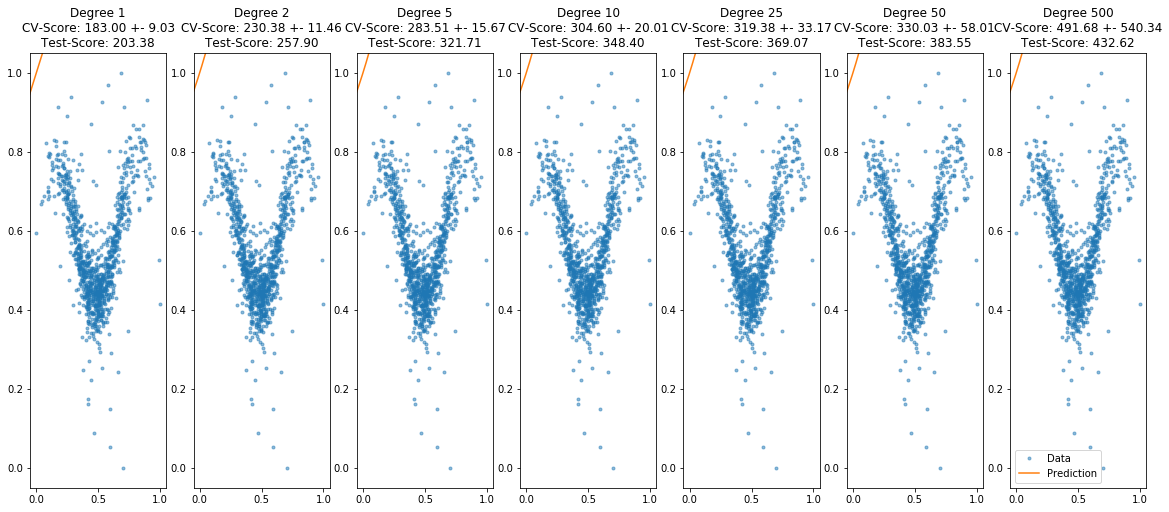

In [150]:
%%time

results = {}
row_results = {}

for i,n in enumerate(degrees):
    polynomial_features = PolynomialFeatures(degree=n) # create instance of transformer
    regression = CustomRegression() # create instance of model

    # make pipeline as list of pairs (<stage name>, <stage object>):
    pipeline = Pipeline([("polynomial_features", polynomial_features), # augment data
                         ("linear_regression", regression)]) # apply linear regression

    # from now we can treat pipeline as a single model, applying all stages when using fit() and predict() 
    pipeline.fit(X_train, y_train)

    # Evaluate pipeline using crossvalidation and score() method
    scores = cross_val_score(pipeline, X_train, y_train, cv=10)

    # Make single evaluation on test set
    test_scores = pipeline.score(X_test, y_test)

    # Save results
    results[n] = {
        'CV_mean': scores.mean(),
        'CV_std': scores.std(),
        'Test': test_scores
    }
    row_results[n] = scores

    # Plot results
    line_x = np.linspace(-0.1, 1.1, 1000).reshape(1000, 1)
    line_y = pipeline.predict(line_x)

    ax = plt.subplot(1, len(degrees), i + 1)
    ax.plot(X, y, '.', alpha=0.5, label='Data')
    ax.autoscale(enable=False)
    ax.plot(line_x, line_y, '-', label='Prediction')

    plt.title("Degree %i\nCV-Score: %.2f +- %.2f\nTest-Score: %.2f"%(n, results[n]['CV_mean'], results[n]['CV_std'], results[n]['Test']))

plt.legend()

In [151]:
import pandas as pd

In [152]:
# simple way to see best runs
results = pd.DataFrame(results).T
results.style.highlight_min()

,CV_mean,CV_std,Test
1,183.002,9.02638,203.375
2,230.381,11.4577,257.902
5,283.51,15.6704,321.709
10,304.601,20.0137,348.405
25,319.383,33.1652,369.069
50,330.035,58.0081,383.549
500,491.678,540.341,432.621


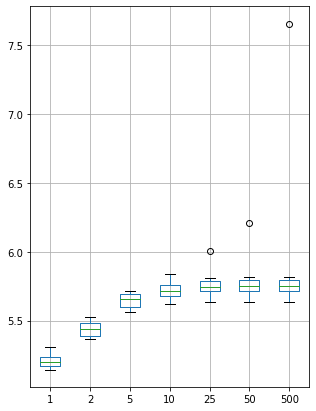

In [153]:
# simple way to visualize model's quality and stability
# using log because of possibly huge outliers on high degrees. Remove it, if everything is  ok.
pd.DataFrame(row_results).apply(np.log).boxplot(figsize=(5, 7))

Analyze results and describe proper way to chose model (be carefull, there is intentional error in the last procedure with cross-validation)